# Classifier calibration plots

This notebook generates classifier calibration plots plots on the adult data, Fig 2 in the paper -- Synthsonic: Fast, Probabilistic modeling and Synthesis of Tabular Data

In [1]:
import logging

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
from sdgym import load_dataset
from phik.phik import phik_from_binned_array
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks

## Config

In [2]:
SAVE_PLOTS = False

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.max_open_warning'] = 0
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
markers = ['o', 's', 'p', 'x', '^', '+', '*', '<', 'D', 'h', '>']
%matplotlib inline

## Dataset

In [5]:
dataset_name = 'adult'

In [6]:
data, categorical_columns, ordinal_columns = load_dataset(dataset_name)
data = np.float64(data)

INFO:sdgym.data:Loading dataset adult


In [7]:
data.shape

(22561, 15)

In [8]:
categorical_columns, ordinal_columns

([1, 5, 6, 7, 8, 9, 13, 14], [3])

In [9]:
all_features = list(range(data.shape[1]))
numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))

n_samples = data.shape[0]
n_features = data.shape[1]

## Fit

In [10]:
clf = xgb.XGBClassifier(
    n_estimators=250,
    reg_lambda=1,
    gamma=0,
    max_depth=9
)

In [11]:
kde = KDECopulaNNPdf(
    use_KDE=False, 
    numerical_columns=numerical_features,
    categorical_columns=categorical_columns+ordinal_columns,
    distinct_threshold=-1,
    n_uniform_bins=30,
    n_calibration_bins=100,
    test_size=0.25,
    edge_weights_fn=phik_from_binned_array
)

In [12]:
kde = kde.fit(data)

INFO:KDECopulaNNPdf:Processing 6 numerical and 9 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).
INFO:KDECopulaNNPdf:n_uniform_bins = 30
Building tree: 100%|██████████| 91/91.0 [00:03<00:00, 28.01it/s]
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 266920 data points.
Generating for node: 6: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s] 
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 15 features.
INFO:KDECopulaNNPdf:Calibrating classifier
INFO:KDECopulaNNPdf:n_calibration_bins = 100
INFO:KDECopulaNNPdf:Maximum weight: 19.596559631901236


## Callibrate classifier

The below function is taken from `synthsonic.KDECopulaNNPdf._calibrate_classifier` witht the only change returning the required values for the plots and making the plots outside the function

In [13]:
def _calibrate_classifier(hist_p0, hist_p1, bin_edges, use_sample_weights=True, validation_plots=False):
    """ Calibrate classifier based on probability histograms

    :param hist_p0:
    :param hist_p1:
    :param bin_edges:
    :return:
    """
    hist_p0 = hist_p0.astype(float)
    hist_p1 = hist_p1.astype(float)
    rest_p0 = np.sum(hist_p0) - hist_p0
    rest_p1 = np.sum(hist_p1) - hist_p1
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    bin_width = bin_edges[1] - bin_edges[0]

    def poisson_uncertainty(n):
        # return correct poisson counts (set to one for zero counts)
        sigma_n = np.sqrt(n)
        sigma_n[sigma_n == 0] = 1.
        return sigma_n

    sigma_bin0 = poisson_uncertainty(hist_p0)
    sigma_rest0 = poisson_uncertainty(rest_p0)
    sigma_bin1 = poisson_uncertainty(hist_p1)
    sigma_rest1 = poisson_uncertainty(rest_p1)

    def fraction_and_uncertainty(a, b, sigma_a, sigma_b):
        # return fraction a/(a+b) and uncertainty on it, given uncertainties on a and b
        sum_ab = a + b
        frac_a = np.divide(a, sum_ab, out=np.zeros_like(a), where=sum_ab != 0)
        frac_b = np.divide(b, sum_ab, out=np.zeros_like(b), where=sum_ab != 0)
        sigma_p1 = np.divide(frac_b * sigma_a, sum_ab, out=np.zeros_like(frac_b), where=sum_ab != 0)
        sigma_p2 = np.divide(frac_a * sigma_b, sum_ab, out=np.zeros_like(frac_a), where=sum_ab != 0)
        sigma_fa2 = np.power(sigma_p1, 2) + np.power(sigma_p2, 2)
        return frac_a, np.sqrt(sigma_fa2)

    frac0, sigma_frac0 = fraction_and_uncertainty(hist_p0, rest_p0, sigma_bin0, sigma_rest0)
    frac1, sigma_frac1 = fraction_and_uncertainty(hist_p1, rest_p1, sigma_bin1, sigma_rest1)
    p1cb, sigma_p1cb = fraction_and_uncertainty(frac1, frac0, sigma_frac1, sigma_frac0)

    # sample weight is set to zero in case both sigma_p1cb is zero
    sample_weight = np.divide(1., sigma_p1cb * sigma_p1cb, out=np.zeros_like(sigma_p1cb), where=sigma_p1cb != 0)
    sample_weight /= np.min(sample_weight[sample_weight > 0])
    sample_weight = sample_weight if use_sample_weights else None

    # make sure last entry is filled, from which max_weight is derived
    if p1cb[-1] == 0:
        filled = p1cb[(p1cb > 0) & (p1cb < 1)]
        if len(filled) > 0:
            p1cb[-1] = np.max(filled)
            if use_sample_weights:
                sample_weight[-1] = 1e-3

    iso_reg = IsotonicRegression(y_min=0, y_max=1, increasing='auto').fit(bin_centers, p1cb, sample_weight)
    p1pred = iso_reg.predict(bin_centers)
    p1f_ = interpolate.interp1d(
        bin_edges[:-1],
        p1pred,
        kind='previous',
        bounds_error=False,
        fill_value="extrapolate"
    )
    max_p1f = np.max(p1pred)
    max_weight = max_p1f / (1. - max_p1f)
    return p1cb, sigma_p1cb, p1pred, max_weight

In [14]:
bin_edges = kde.bin_edges_
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = kde.bin_centers_
hist_p0 = kde.hist_p0_
hist_p1 = kde.hist_p1_

In [15]:
p1cb, sigma_p1cb, p1pred, max_weight = _calibrate_classifier(hist_p0, hist_p1, bin_edges, use_sample_weights=True)

In [16]:
# confidence interval
sigma_p1cb_95 = sigma_p1cb * 1.96
sigma_lb = p1cb - sigma_p1cb_95
sigma_ub = p1cb + sigma_p1cb_95

In [17]:
max_weight

19.596559631901236

#### Fig 2a Classifier scores

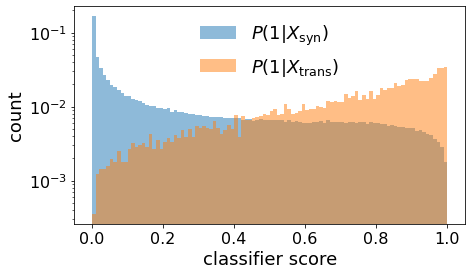

In [18]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(bin_centers, hist_p0 / np.sum(hist_p0), width=bin_width, alpha=0.5, label=r'$P(1|X_{\rm syn})$', log=True, color=colors[0])
ax.bar(bin_centers, hist_p1 / np.sum(hist_p1), width=bin_width, alpha=0.5, label=r'$P(1|X_{\rm trans})$', log=True, color=colors[1])
ax.legend(fontsize=18, frameon=False)
ax.tick_params(labelsize=16)
ax.set_ylabel('count', fontsize=18)
ax.set_xlabel('classifier score', fontsize=18)

if SAVE_PLOTS:
    fig.savefig(f'{dataset_name}_callibration_clf_hists.pdf', dpi=600, bbox_inches='tight')

#### Fig 2b classifier curves

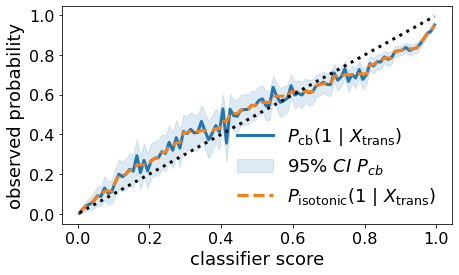

In [19]:
fig, ax = plt.subplots(figsize=(7, 4))
pcb = ax.plot(bin_centers, p1cb, label=r'$P_{\rm cb}(1~|~X_{\rm trans})$', lw=3, color=colors[0])
ci = ax.fill_between(bin_centers, sigma_lb, sigma_ub, label=r'$95\%~CI~P_{cb}$', color=colors[0], alpha=0.15)
piso = ax.plot(bin_centers, p1pred, label=r'$P_{\rm isotonic}(1~|~X_{\rm trans})$', lw=3, ls='--', color=colors[1])
pline = ax.plot(bin_centers, bin_centers, lw=3, ls=':', color='black')
ax.set_ylabel('observed probability', fontsize=18)
ax.set_xlabel('classifier score', fontsize=18)
ax.tick_params(labelsize=16)

handles, labels = ax.get_legend_handles_labels()
handles_corr = [handles[0], handles[2], handles[1]]
labels_corr = [labels[0], labels[2], labels[1]]
ax.legend(handles_corr, labels_corr, fontsize=18, frameon=False)

if SAVE_PLOTS:
    fig.savefig(f'{dataset_name}_callibration_pcb_plot.pdf', dpi=600, bbox_inches='tight')